In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from utils.calc_time import format_data
# 超参数
num_epochs = 1000
batch_size = 32
num_classes = 5
num_shots = 1 # 每个类别的样本数
num_tasks = 32 # 元学习任务数
lr_inner = 0.4 # 内部学习率
lr_outer = 0.1 # 外部学习率

In [2]:
import torch.nn.functional as F
class MLP(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output, dropout=0.5):
        super(MLP, self).__init__()
        self.dropout = torch.nn.Dropout(dropout)

        self.hidden_1 = torch.nn.Linear(n_feature, n_hidden)  # hidden layer
        self.bn1 = torch.nn.BatchNorm1d(n_hidden)

        self.hidden_2 = torch.nn.Linear(n_hidden, n_hidden//2)
        self.bn2 = torch.nn.BatchNorm1d(n_hidden//2)

        self.hidden_3 = torch.nn.Linear(n_hidden//2, n_hidden//4)  # hidden layer
        self.bn3 = torch.nn.BatchNorm1d(n_hidden//4)

        self.hidden_4 = torch.nn.Linear(n_hidden // 4, n_hidden // 8)  # hidden layer
        self.bn4 = torch.nn.BatchNorm1d(n_hidden // 8)

        self.out = torch.nn.Linear(n_hidden//8, n_output)  # output layer

    def forward(self, x):
        x = F.relu(self.hidden_1(x))  # activation function for hidden layer
        x = self.dropout(self.bn1(x))
        x = F.relu(self.hidden_2(x))  # activation function for hidden layer
        x = self.dropout(self.bn2(x))
        x = F.relu(self.hidden_3(x))  # activation function for hidden layer
        x = self.dropout(self.bn3(x))
        x = F.relu(self.hidden_4(x))  # activation function for hidden layer
        x = self.dropout(self.bn4(x))
        x = self.out(x)
        return x

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils import data
import numpy as np
from utils import parse_opts
import warnings
warnings.filterwarnings("ignore")
def load_data(path):
    # 读取合并X和Y
    df = pd.read_csv(path)
    # df['feature'] = df.path.parallel_apply(lambda x:env2vec(x.replace('./','env/')).flatten().tolist())
    # df.to_feather('/home/linjw/iProject/HA-Prototypical/env/env2vec.feather')
    df = pd.read_feather('../env/env2vec.feather')
    return df

def process_data(df, mode, type = 'MAML'):
    if mode != 'test' and type != 'MLP':
        df = np.vstack((df.values, df.values))
    else:
        df = df.values
    x = np.array(df[:,-1])
    x = np.array([list(i) for i in x],dtype=np.float32)
    y = [np.array(eval(i)).flatten() for i in df[:,-3]]
    y = np.array([list(x) for x in y])
    y_index = np.arange(len(y)) % (len(y)/2 if mode != 'test' else len(y)/2)
    return x, y_index, {i: y[i] for i in range(len(y))}, y

# 定义MAML_Dataset类
class MAML_Dataset(data.Dataset):
    def __init__(self, mode, path, test_size=0.2, random_state=0):
        super().__init__()
        # self.sample_len = 1024
        self.df = load_data(path)
        self.train_df, self.test_df = train_test_split(self.df, test_size=test_size, random_state=random_state)
        self.x, self.y, self.label_dict, _ = process_data(self.train_df if mode != 'test' else self.test_df,mode)

    def __getitem__(self, index):
        x = np.array(self.x[index],dtype=np.float32)
        y = self.y[index]
        return x, y

    def __len__(self):
        return len(self.x)

In [4]:
dataset = MAML_Dataset('train',path='../env/bob_info.csv')

In [5]:
dataset.train_df

,path,class,excel_num,bob,fitness,feature
336,./case4/36.xlsx,4,36,"[[34, 0, 0], [64, 1, 0], [34, 0, 1], [64, 1, 1...",56738.907,"[6.0, 15.0, 51.0, 507.0, 97.5, 15.0, 16.0, 26...."
64,./case1/64.xlsx,1,64,"[[7, 0, 0], [8, 1, 0], [7, 0, 1], [8, 1, 1], [...",31320.819,"[9.0, 18.0, 54.0, 558.0, 135.0, 11.0, 8.0, 14...."
55,./case1/55.xlsx,1,55,"[[31, 0, 0], [26, 1, 0], [31, 0, 1], [26, 1, 1...",29120.865,"[18.0, 12.0, 39.0, 351.0, 78.0, 11.0, 9.0, 9.0..."
106,./case2/6.xlsx,2,6,"[[37, 0, 0], [45, 1, 0], [37, 0, 1], [45, 1, 1...",14916.774,"[12.0, 12.0, 18.0, 450.0, 72.0, 12.0, 11.0, 14..."
300,./case4/0.xlsx,4,0,"[[74, 0, 0], [54, 1, 0], [74, 0, 1], [54, 1, 1...",73493.004,"[6.0, 27.0, 51.0, 459.0, 175.5, 18.0, 21.0, 26..."
...,...,...,...,...,...,...
323,./case4/23.xlsx,4,23,"[[41, 0, 0], [9, 1, 0], [41, 0, 1], [9, 1, 1],...",61043.268,"[9.0, 27.0, 45.0, 381.0, 162.0, 16.0, 10.0, 21..."
192,./case2/92.xlsx,2,92,"[[8, 0, 0], [39, 1, 0], [8, 0, 1], [39, 1, 1],...",14020.836,"[18.0, 3.0, 78.0, 366.0, 16.5, 10.0, 5.0, 8.0,..."
117,./case2/17.xlsx,2,17,"[[5, 0, 0], [64, 1, 0], [5, 0, 1], [64, 1, 1],...",15038.208,"[18.0, 6.0, 78.0, 390.0, 39.0, 6.0, 11.0, 8.0,..."
47,./case1/47.xlsx,1,47,"[[39, 0, 0], [71, 1, 0], [39, 0, 1], [71, 1, 1...",25207.200,"[21.0, 18.0, 75.0, 555.0, 99.0, 7.0, 9.0, 13.0..."


In [6]:
np.array([list(x) for x in dataset.train_df['feature'].values])

array([[ 6., 15., 51., ...,  0.,  0.,  0.],
       [ 9., 18., 54., ...,  0.,  0.,  0.],
       [18., 12., 39., ...,  0.,  0.,  0.],
       ...,
       [18.,  6., 78., ...,  0.,  0.,  0.],
       [21., 18., 75., ...,  0.,  0.,  0.],
       [18.,  9.,  9., ...,  0.,  0.,  0.]])

In [7]:
np.array([list(eval(x)) for x in dataset.train_df['bob'].values]).reshape(-1,450)

array([[34,  0,  0, ..., 72,  0,  1],
       [ 7,  0,  0, ..., 60,  0,  1],
       [31,  0,  0, ...,  9,  0,  1],
       ...,
       [ 5,  0,  0, ..., 24,  0,  1],
       [39,  0,  0, ..., 11,  0,  1],
       [32,  0,  0, ..., 28,  0,  1]])

In [8]:
train_x = torch.from_numpy(np.array([list(x) for x in dataset.train_df['feature'].values])).float()
train_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.train_df['bob'].values]).reshape(-1,450)).float()
test_x = torch.from_numpy(np.array([list(x) for x in dataset.test_df['feature'].values])).float()
test_y = torch.from_numpy(np.array([list(eval(x)) for x in dataset.test_df['bob'].values]).reshape(-1,450)).float()

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
input_size = 151  # 输入特征的维度
output_size = 151  # 输出特征的维度
learning_rate = 0.01  # 学习率

model=MLP(756, 256, 450)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
num_epochs = 400  # 迭代次数
train_losses = []
test_losses = []
for epoch in range(num_epochs):
    # 前向传播
    inputs = train_x
    labels = train_y
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    
    # 反向传播和优化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每迭代10次打印一次损失
    # 每迭代10次打印一次损失
    with torch.no_grad():
        inputs = test_x
        labels = test_y
        predicted = model(inputs)
        loss_ = criterion(predicted, labels)
        train_losses.append(loss.item())
        test_losses.append(loss_.item())
        print('Epoch [{}/{}], Train Loss: {:.4f}, Test Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item(), loss_.item()))

Epoch [1/400], Train Loss: 613.6451, Test Loss: 613.7579
Epoch [2/400], Train Loss: 613.5211, Test Loss: 613.7944
Epoch [3/400], Train Loss: 613.3662, Test Loss: 613.4855
Epoch [4/400], Train Loss: 613.4052, Test Loss: 613.3344
Epoch [5/400], Train Loss: 613.2975, Test Loss: 613.3525
Epoch [6/400], Train Loss: 613.4014, Test Loss: 613.3591
Epoch [7/400], Train Loss: 613.1027, Test Loss: 613.2959
Epoch [8/400], Train Loss: 613.0460, Test Loss: 613.0469
Epoch [9/400], Train Loss: 613.2396, Test Loss: 613.0956
Epoch [10/400], Train Loss: 613.1319, Test Loss: 612.7589
Epoch [11/400], Train Loss: 613.1172, Test Loss: 612.8707
Epoch [12/400], Train Loss: 612.9213, Test Loss: 612.7572
Epoch [13/400], Train Loss: 612.9858, Test Loss: 612.9398
Epoch [14/400], Train Loss: 612.7079, Test Loss: 612.8521
Epoch [15/400], Train Loss: 612.6817, Test Loss: 612.7031
Epoch [16/400], Train Loss: 612.7906, Test Loss: 612.5268
Epoch [17/400], Train Loss: 612.8800, Test Loss: 612.5844
Epoch [18/400], Train L

In [10]:
pd.DataFrame([train_losses,test_losses],index=['train_error','valid_error']).T.to_csv('result/MLP_loss.csv',index=False)

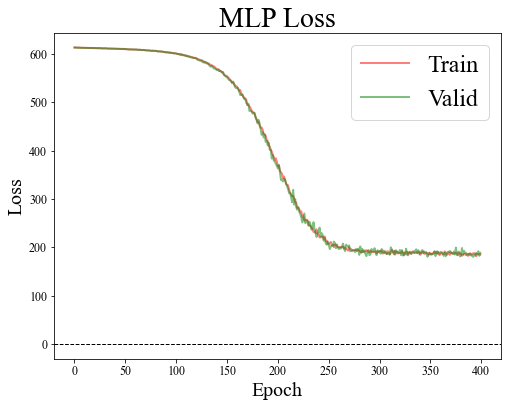

In [11]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('font',family='Times New Roman')
# 生成随机数据
x = np.arange(0, 400)
y1 = train_losses
y2 = test_losses
# 计算移动平均值
window_size = 10
window = np.ones(window_size) / float(window_size)
y_smooth = np.convolve(y1, window, 'same')

# 绘图
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(x, y1, alpha=0.5, color='red', linewidth=2, label='Train')
ax.plot(x, y2, alpha=0.5, color='green', linewidth=2, label='Valid')
# 界限线
ax.axhline(y=0, linestyle='--', color='black', linewidth=1)
# 标题和标签
ax.set_title('MLP Loss', fontsize=28)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylabel('Loss', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=12)
# 图例
ax.legend(loc='best', fontsize=24)

plt.show()

In [12]:
test_df=dataset.test_df
test_df.index=range(len(test_df))

In [13]:
import sys
sys.path.append('../heuristic')
from methods.common import parse_env,ruler,calculate_cost,fitness

In [14]:
product_list=[ruler(x.reshape(150,3),75) for x in predicted.numpy()]
product_list

[[[43, 1, 0],
  [35, 0, 0],
  [1, 0, 0],
  [10, 0, 0],
  [30, 1, 0],
  [33, 0, 0],
  [33, 0, 1],
  [9, 1, 0],
  [32, 0, 0],
  [5, 1, 0],
  [41, 1, 0],
  [25, 1, 0],
  [58, 1, 0],
  [3, 1, 0],
  [55, 0, 0],
  [31, 1, 0],
  [24, 0, 0],
  [13, 1, 0],
  [53, 0, 0],
  [36, 1, 0],
  [54, 1, 0],
  [22, 1, 0],
  [19, 0, 0],
  [26, 1, 0],
  [49, 1, 0],
  [16, 0, 0],
  [64, 0, 0],
  [37, 1, 0],
  [67, 0, 0],
  [7, 1, 0],
  [71, 0, 0],
  [20, 1, 0],
  [31, 0, 1],
  [45, 1, 0],
  [38, 0, 0],
  [59, 1, 0],
  [3, 0, 1],
  [41, 0, 1],
  [53, 0, 1],
  [9, 0, 1],
  [60, 1, 0],
  [40, 1, 0],
  [74, 0, 0],
  [15, 0, 0],
  [66, 1, 0],
  [22, 0, 1],
  [67, 1, 1],
  [51, 1, 0],
  [2, 0, 0],
  [14, 1, 0],
  [54, 1, 1],
  [20, 1, 1],
  [42, 0, 0],
  [39, 1, 0],
  [62, 0, 0],
  [50, 0, 0],
  [46, 0, 0],
  [0, 0, 0],
  [11, 0, 0],
  [4, 1, 0],
  [68, 1, 0],
  [47, 1, 0],
  [73, 0, 0],
  [48, 1, 0],
  [74, 1, 1],
  [44, 1, 0],
  [72, 1, 0],
  [52, 0, 0],
  [61, 0, 0],
  [62, 1, 1],
  [69, 0, 0],
  [40, 0, 1],
  

In [15]:
predicted_time_list = []
for i, file_name in test_df.iterrows():
    excel_name = file_name['path'].replace('./','../env/')
    order = product_list[i]
    J, M, A, D, N, pt, p, W = parse_env(excel_name)
    predicted_time_list.append(-fitness(order, J, M, A, D, N, pt, p, W))
predicted_time_list = format_data(predicted_time_list,0) #32 25 22
# Convert the object results for the test dataset to a list
true_time_list = test_df['fitness'].values.tolist()


# Calculate the performance metrics
error_list = []
percent_error_list = []
for i in range(len(true_time_list)):
    true_time_list[i] = float(true_time_list[i])
    predicted_time_list[i] = float(predicted_time_list[i])
    error_list.append(true_time_list[i] - predicted_time_list[i])
    percent_error_list.append((true_time_list[i] - predicted_time_list[i]) / true_time_list[i])

# Create a dataframe with the performance metrics and write it to an Excel file
performance_df = pd.DataFrame(columns=['average error', 'average percent error', 'predicted time average', 'predicted time max', 'predicted time min'])
performance_df.loc[0] = [sum(error_list)/len(error_list), sum(percent_error_list)/len(percent_error_list), sum(predicted_time_list)/len(predicted_time_list), max(predicted_time_list), min(predicted_time_list)]

In [16]:
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T.to_csv('./output/MLP_label.csv',index=False) 
pd.DataFrame([true_time_list,predicted_time_list],index=['Predict','GroundTruth']).T

,Predict,GroundTruth
0,14252.853,15445.044400
1,62381.997,75488.651042
2,59972.889,68659.227026
3,16997.133,19179.594668
4,32224.176,37808.717277
...,...,...
75,29295.540,34337.391701
76,59167.452,73122.872667
77,64591.020,75062.111038
78,58910.796,70303.753152


In [17]:
performance_df

,average error,average percent error,predicted time average,predicted time max,predicted time min
0,-6603.737638,-0.19484,39208.927663,93395.118128,14427.595761
